# Generative Models as Data Augmentation in the Medical Domain

## 1. Overview

This project tries to evaluate the quality of generative models for data augmentation in the medical domain. 

Data augmentation will be relying on geometric data augmentation, (variational) auto-encoder (e.g. stacked denoising, denoising auto-encoder, etc.), and generative adversarial neural networks (e.g. GAN, DCGAN, Wasserstein GAN, etc.) for instance.

We will restrict ourself to three kind of models to generate new data and evaluate the (possible) improvement with regards to a final classification score (i.e. comparing results between augmented and non-augmented training sets). 

### Datasets

We will look into applying the above project on some (if not all) of the following datasets from the MedMNIST Classification Decathlon (https://medmnist.github.io/):

| Dataset | Classification Type | Train size | Validation size | Test size |
| :--- | :--- | :---: | :---: | :---: |  
| PathMNIST Pathology | Multi-Class (9) | 89,996 | 10,004 | 7,180 |
| DermaMNIST Dermatoscope | Multi-Class (7) | 7,007 | 1,003 | 2,005 |
| OCTMNIST OCT | Multi-Class (4) | 97,477 | 10,832 | 1,000 |
| PneumoniaMNIST Chest X-ray | Binary-Class (2) |4,708 | 524 | 624 |
| BreastMNIST Breast Ultrasound | Binary-Class (2) | 546 | 78 | 156 |
| OrganMNIST_Axial Abdominal CT | Multi-Class (11) | 34,581 | 6,491 | 17,778 |
| OragnMNIST_Coronal Abdominal CT | Multi-Class (11) |13,000 | 2,392 | 8,268 |
| OrganMNIST_Sagittal Abdominal CT | Multi-Class (11) | 13,940 | 2,452 | 8,829 |

### Notes

We will also provide a short report (in copy) explaining the choice of VAE, AE, and/or GAN models, outlining differences between datasets' results. We will also try to interprete and justify possible differences with regards to models, data specifications, visual features, and bibliography references used to support the choices made.

## 2. Data and Library Imports

### Source

We will retrieve the above dataset from the following website:

> [MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification](https://medmnist.com/), Jiancheng Yang,Rui Shi,Donglai Wei,Zequan Liu,Lin Zhao,Bilian Ke,Hanspeter Pfister,Bingbing Ni

By following the instructions on their [github](https://github.com/MedMNIST/MedMNIST), we can download their ready-made module with the following instruction:

```sh
pip install jupyter, ipywidgets, IProgress
pip install medmnist
```

And load it in a python or ipython instance:

```python
import medmnist
```

### Library Imports

In [1]:
from python_scripts.classifier import run_classifier_pipeline
from python_scripts.conditional_vae import run_encoder_pipeline, one_hot
from python_scripts.data import retrieve_flag_info, import_dataset
from python_scripts.data import check_cuda_availability

import warnings
warnings.filterwarnings('ignore')

### Checks CUDA availability

In [2]:
check_cuda_availability()

True,0,<torch.cuda.device object at 0x7f87283f3a90>,1
NVIDIA GeForce GTX 980 Ti


### Data Imports

In [3]:
data_flags = ["pathmnist", "dermamnist", "octmnist", "pneumoniamnist", 
              "breastmnist", "organamnist", "organcmnist", "organsmnist"]

info_flags = {flag:retrieve_flag_info(flag) for flag in data_flags}

In [ ]:
pathmnist = import_dataset("pathmnist", info_flags)

Using downloaded and verified file: /home/quentin/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/dermamnist.npz
Montage of randomly extracted images from the dataset:


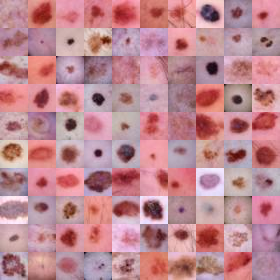

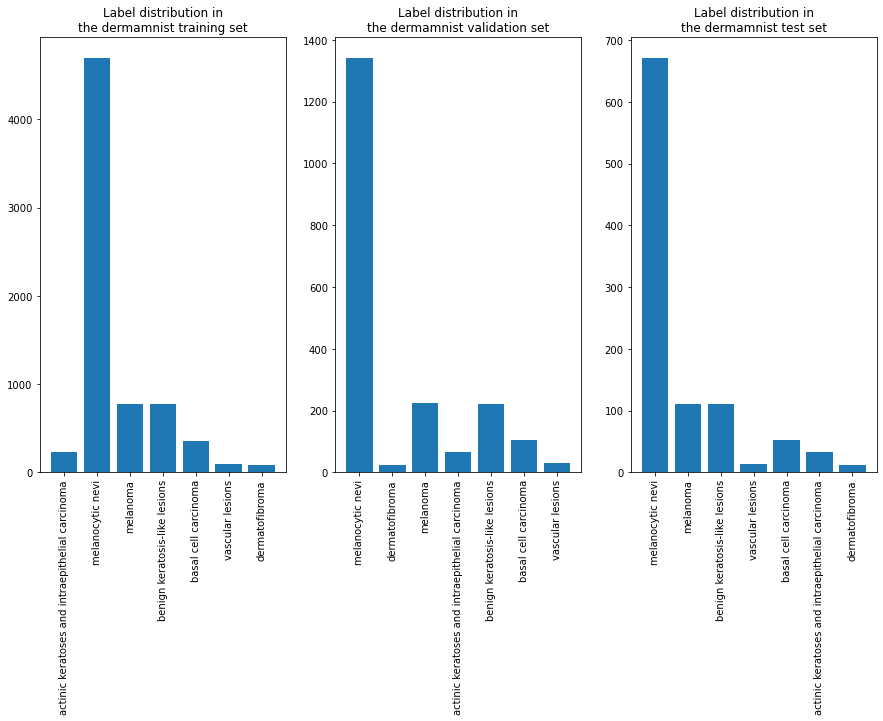

In [4]:
dermamnist = import_dataset("dermamnist", info_flags)

In [ ]:
octmnist = import_dataset("octmnist", info_flags)

In [ ]:
pneumoniamnist = import_dataset("pneumoniamnist", info_flags)

In [ ]:
breastmnist = import_dataset("breastmnist", info_flags)

In [ ]:
organamnist = import_dataset("organamnist", info_flags)

In [ ]:
organcmnist = import_dataset("organcmnist", info_flags)

In [ ]:
organsmnist = import_dataset("organsmnist", info_flags)

## 3. Training a Classifier Without Data Augmentation

### PathMNIST

In [ ]:
clf_pathmnist = run_classifier_pipeline("pathmnist", info_flags, pathmnist)

### DermaMNIST

In [ ]:
clf_dermamnist = run_classifier_pipeline("dermamnist", info_flags, dermamnist)

### OctMNIST

In [ ]:
clf_octmnist = run_classifier_pipeline("octmnist", info_flags, octmnist)

### PneumoniaMNIST

In [ ]:
clf_pneumoniamnist = run_classifier_pipeline("pneumoniamnist", info_flags, pneumoniamnist)

### BreastMNIST

In [ ]:
clf_breastmnist = run_classifier_pipeline("breastmnist", info_flags, breastmnist)

### OrganAMNIST

In [ ]:
clf_organamnist = run_classifier_pipeline("organamnist", info_flags, organamnist)

### OrganCMNIST

In [ ]:
clf_organcmnist = run_classifier_pipeline("organcmnist", info_flags, organcmnist)

### OrganSMNIST

In [ ]:
clf_organsmnist = run_classifier_pipeline("organsmnist", info_flags, organsmnist)

## 4. Training a Conditional Variational Autoencoder for Data Augmentation

### PathMNIST

### DermaMNIST

In [ ]:
n_classes  = len(info_flags["dermamnist"][0]["label"])
n_channels = info_flags["dermamnist"][0]["n_channels"]
laten_dims = 100; epochs = 30

train_loader = dermamnist[3]; val_loader = dermamnist[5]; test_loader = dermamnist[4]

model = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, n_classes, laten_dims, epochs, 
    "dermamnist", 
    output_intermediary_images=True
)

Testing Conditional Variational Autoencoder:
Model Output size: torch.Size([10, 3, 28, 28])
Forward pass test:  True
{'loss': tensor(26467.1465, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(26467.0820, grad_fn=<MseLossBackward0>), 'KLD': tensor(-12.7571, grad_fn=<NegBackward0>)}
Loss test:  True
Cuda device:  cuda
Training phase:
Train epoch 1: [0/7007] 	Loss: 866.53772
Train epoch 1: [1280/7007] 	Loss: 119.515816
Train epoch 1: [2560/7007] 	Loss: 116.096184


In [85]:
import torch

img = model.sample(1, one_hot(torch.Tensor([1]).int().to(torch.device("cuda")), 7))

In [78]:
img.detach().cpu().numpy().reshape([3, 28, 28]).T.shape

(28, 28, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


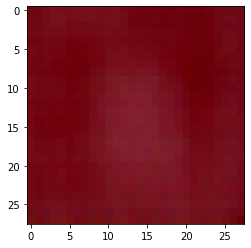

In [86]:
import matplotlib.pyplot as plt
def show_images(images) -> None:
    n: int = len(images)
    f = plt.figure()
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])

    plt.show(block=True)
    
show_images([img.detach().cpu().numpy().reshape([3, 28, 28]).T])

### OctMNIST

### PneumoniaMNIST

### BreastMNIST

### OrganAMNIST

### OrganCMNIST

### OrganSMNIST